In [1]:
# Importation des modules necessaires
import sys
sys.path.insert(0,'../')
import argopy
import xarray as xr
import glob
import numpy as np
from m_argo_data import read_argo_data_for_NCEP
from m_NCEP_data import *
import warnings
warnings.filterwarnings("ignore",category=RuntimeWarning)
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit

In [2]:
#
# Init.
#
num_float = '6902802'
rep_data_argo = '/Users/chemon/ARGO_NEW/NEW_LOCODOX/data_test/'
rep_NCEP_data= '/Users/chemon/ARGO_NEW/LOCODOX/DATA/LOCODOX_EXTERNAL_DATA/NCEP/'

which_psal = 1
code_inair = [699,711,799]
code_inwater = [690,710]

In [3]:
# Lecture donnees ARGO
dsair,dsinwater,optode_height,launch_date = read_argo_data_for_NCEP(num_float,rep_data_argo,which_psal,code_inair,code_inwater)

In [4]:
# Chargement des donnees NCEP si besoin
ftp_server = 'ftp.cdc.noaa.gov'
rep_ftp = 'Datasets/ncep.reanalysis/surface'
rep_local = '/Users/chemon/ARGO_NEW/NEW_LOCODOX/NCEP_DATA/'
ncep_variables = ['slp','air.sig995','rhum.sig995']

In [5]:
download_NCEP(dsair['JULD'],ftp_server,rep_ftp,rep_local,ncep_variables)

Telechargement des donnees NCEP si besoin
File slp.2018.nc already exists.
File air.sig995.2018.nc already exists.
File rhum.sig995.2018.nc already exists.
File slp.2019.nc already exists.
File air.sig995.2019.nc already exists.
File rhum.sig995.2019.nc already exists.
File slp.2020.nc already exists.
File air.sig995.2020.nc already exists.
File rhum.sig995.2020.nc already exists.
File slp.2021.nc already exists.
File air.sig995.2021.nc already exists.
File rhum.sig995.2021.nc already exists.
File slp.2022.nc already exists.
File air.sig995.2022.nc already exists.
File rhum.sig995.2022.nc already exists.


In [6]:
# Lecture donnees NCEP et interpolation sur date/position ARGO des donnees InAir.
# Les donnees Inwater sont faites legerement avant les donnees InAir.
ds_NCEP_air,ds_NCEP_slp,ds_NCEP_rhum = read_NCEP(rep_NCEP_data,dsair['LONGITUDE_ARGO'],dsair['LATITUDE_ARGO'],dsair['JULD'])


In [7]:
# Calcul de PPOX_NCEP
z0q = 1e-4
NCEP_PPOX = calcul_NCEP_PPOX(dsinwater,ds_NCEP_air,ds_NCEP_slp,ds_NCEP_rhum,optode_height,z0q)

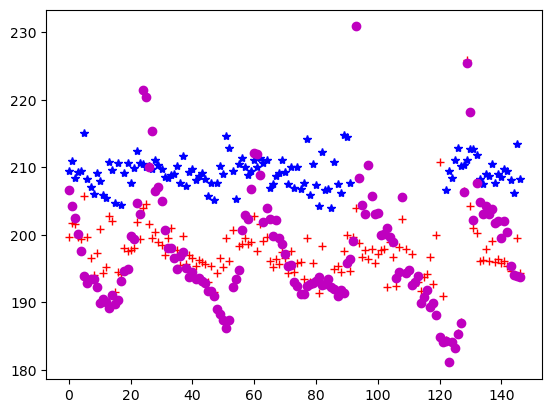

In [8]:
# Trace
plt.figure()
plt.plot(NCEP_PPOX,'*b')
plt.plot(dsair['PPOX_DOXY'],'r+')
plt.plot(dsinwater['PPOX_DOXY'],'om')

In [9]:
# Calcul de la solution avec un simple gain sans et avec Carry_Over
###################################################################
PPOX1 = dsair['PPOX_DOXY'].values
PPOX2 = dsinwater['PPOX_DOXY'].values
delta_T = (dsair['JULD'].values - launch_date)
delta_T = delta_T.astype(float)
delta_T = delta_T/1e9/86400 # Difference en jour

In [10]:
#PPOX1 = PPOX1[0:10]
#PPOX2 = PPOX2[0:10]
#delta_T = delta_T[0:10]
#NCEP_PPOX = NCEP_PPOX[0:10]

In [11]:
print(delta_T)

[  12.13450231   32.13189815   52.13133102   72.12711806   92.12607639
  112.12738426  132.1355787   152.13797454  172.12853009  192.12931713
  212.12711806  222.12835648  232.12364583  242.13126157  252.13141204
  262.1321412   272.13241898  282.12768519  292.13050926  302.13053241
  312.138125    322.12799769  332.1334375   342.13414352  352.13329861
  362.13199074  372.13018519  382.13228009  392.13248843  402.1321412
  412.12949074  422.13440972  432.1333912   442.13368056  452.1321412
  462.13200231  472.12802083  482.13315972  492.13681713  502.13414352
  512.1309838   522.13233796  532.13091435  542.13135417  552.13079861
  562.12802083  572.12810185  582.12755787  592.1266088   602.13643519
  612.12969907  622.13123843  632.12833333  642.13239583  652.13078704
  662.13581019  672.13061343  682.13383102  692.13050926  702.13403935
  712.13054398  722.13092593  732.13118056  742.13388889  752.1340162
  762.13246528  772.13418981  782.1341088   792.13186343  802.1315625
  812.1305

In [12]:
# Calcul Gain sans CarryOver
def model_Gain(X,G):
    return G * X 
    
initial_guess = 1  # Valeurs initiales pour G 
params_Gain, covariance = curve_fit(model_Gain, PPOX1, NCEP_PPOX, p0=initial_guess,nan_policy='omit')
print(params_Gain)
#params_Gain, covariance = curve_fit(model_Gain, PPOX1, NCEP_PPOX, p0=initial_guess,nan_policy='omit',method='dogbox')
#print(params_Gain)

Gain = params_Gain

[1.06150129]


In [13]:
# Calcul Gain avec CarryOver
def model_Gain_CarryOver(X,G,C):
    return G * (X[0] - C * X[1]) / (1 - C) # C : Carry-over

initial_guess = [1, 0]  # Valeurs initiales pour G et C
params_Gain_CarryOver, covariance = curve_fit(model_Gain_CarryOver, [PPOX1,PPOX2], NCEP_PPOX, p0=initial_guess,nan_policy='omit')
print(params_Gain_CarryOver)
#params_Gain_CarryOver, covariance = curve_fit(model_Gain_CarryOver, [PPOX1,PPOX2], NCEP_PPOX, p0=initial_guess,nan_policy='omit',method='trf')
#print(params_Gain_CarryOver)
#params_Gain_CarryOver, covariance = curve_fit(model_Gain_CarryOver, [PPOX1,PPOX2], NCEP_PPOX, p0=initial_guess,nan_policy='omit',method='dogbox')
#print(params_Gain_CarryOver)

Gain_CarryOver,C_estime = params_Gain_CarryOver

[1.06168545 0.09066918]


In [14]:
#def model_Gain_CarryOver(inputs,G,C):
#    PPOX1,PPOX2 = inputs
#    return G * (PPOX1 - C * PPOX2) / (1 - C) # C : Carry-over

#initial_guess = [1, 0]  # Valeurs initiales pour G et C
#params_Gain_CarryOver, covariance = curve_fit(model_Gain_CarryOver, (PPOX1,PPOX2), NCEP_PPOX, p0=initial_guess,nan_policy='omit')
#print(params_Gain_CarryOver)
#params_Gain_CarryOver, covariance = curve_fit(model_Gain_CarryOver, [PPOX1,PPOX2], NCEP_PPOX, p0=initial_guess,nan_policy='omit',method='trf')
#print(params_Gain_CarryOver)
#params_Gain_CarryOver, covariance = curve_fit(model_Gain_CarryOver, [PPOX1,PPOX2], NCEP_PPOX, p0=initial_guess,nan_policy='omit',method='dogbox')
#print(params_Gain_CarryOver)

#Gain_CarryOver,C_estime = params_Gain_CarryOver

In [15]:
print(Gain_CarryOver)

1.0616854503878632


[1.06150129]
1.0616854503878632
1.0626105779781017
1.0624834192310089


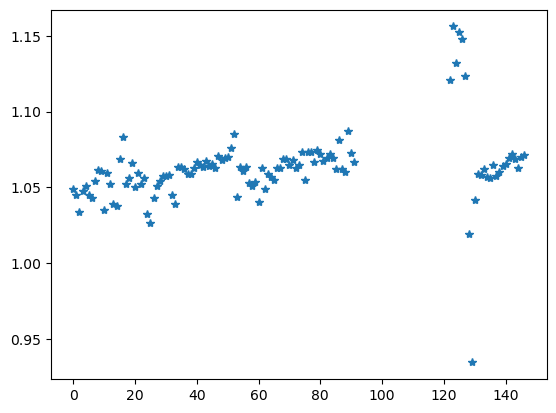

In [16]:
print(Gain)
print(Gain_CarryOver)
print(np.nanmean(NCEP_PPOX/PPOX1))
print(np.nanmedian(NCEP_PPOX/PPOX1))
plt.figure()
plt.plot(NCEP_PPOX/PPOX1,'*')
plt.show()

In [17]:
def model_Gain_Derive(X,G,D):
    return (G * (1 + (D * X[1])/(365*100)) * X[0] )

# Ajustement des paramètres G et D
initial_guess = [1, 0]  # Valeurs initiales pour G et D et C
params_Gain_Derive, covariance,info,mesg,ier = curve_fit(model_Gain_Derive, [PPOX1,delta_T], NCEP_PPOX, p0=initial_guess,nan_policy='omit',full_output=True)
print(params_Gain_Derive)
print(np.sqrt(np.diag(covariance)))
Gain_Derive, Derive = params_Gain_Derive

[1.0505639  0.50892684]
[0.0043184  0.17478419]


In [18]:
print(mesg,ier)

Both actual and predicted relative reductions in the sum of squares
  are at most 0.000000 1


In [34]:
def model_Gain_Derive_CarryOver(X,G,C,D):
    return (G / (1-C) * (1 + D / 100 * X[2]/365) * (X[0] - C * X[1]) )

# Ajustement des paramètres G et D
initial_guess = [1, 0, 0]  # Valeurs initiales pour G et D et C
params_Gain_Derive_CarryOver, covariance = curve_fit(model_Gain_Derive_CarryOver, [PPOX1,PPOX2,delta_T], NCEP_PPOX, p0=initial_guess,nan_policy='omit')

Gain_Derive_CarryOver, C_estime, Derive_CarryOver = params_Gain_Derive_CarryOver
print(Gain_Derive,Derive)
print(Gain_Derive_CarryOver,Derive_CarryOver)

1.0505639024882532 0.5089268375093455
1.0491167424077168 0.5904557336542134


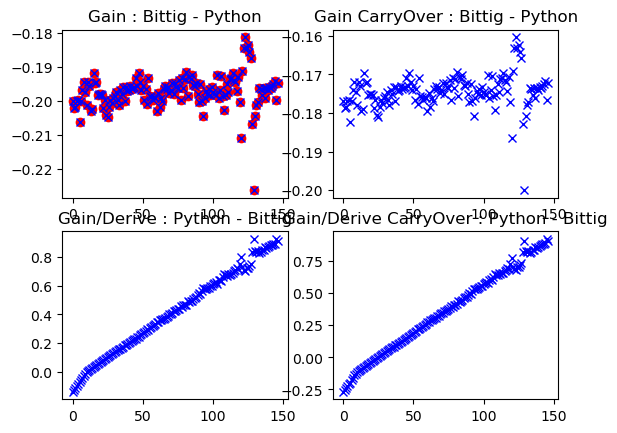

In [20]:
Gain_Derive_bittig = 1.0513
Derive_bittig = 0.389
Gain_Derive_bittig_CarryOver = 1.0505
Derive_bittig_CarryOver = 0.456
Gain_bittig = 1.0605
Gain_bittig_CarryOver = 1.0608

plt.figure()
plt.subplot(2,2,1)
plt.plot(Gain_bittig *  PPOX1 - Gain * PPOX1,'or')
plt.plot(Gain_bittig *  PPOX1 - model_Gain(PPOX1,*params_Gain),'xb')
plt.title('Gain : Bittig - Python')
plt.subplot(2,2,2)
#plt.plot(Gain_bittig_CarryOver *  PPOX1 - model_Gain_CarryOver([PPOX1,PPOX2],*params_Gain_CarryOver),'or')
plt.plot(Gain_bittig_CarryOver *  PPOX1 - Gain_CarryOver * PPOX1,'xb')

plt.title('Gain CarryOver : Bittig - Python')
plt.subplot(2,2,3)
plt.plot(Gain_Derive * (1 + Derive / 100 * delta_T/365) * PPOX1 - Gain_Derive_bittig * (1 + Derive_bittig / 100 * delta_T/365) * PPOX1,'xb')
plt.title('Gain/Derive : Python - Bittig')
plt.subplot(2,2,4)
plt.plot(Gain_Derive_CarryOver * (1 + Derive_CarryOver / 100 * delta_T/365) * PPOX1 - Gain_Derive_bittig_CarryOver * (1 + Derive_bittig_CarryOver / 100 * delta_T/365) * PPOX1,'xb')
plt.title('Gain/Derive CarryOver : Python - Bittig')
plt.show()

In [42]:
# Calcul de la derive comme Locodox
#
valid_index = np.isfinite(NCEP_PPOX)
PPOX1 = PPOX1[valid_index]
PPOX2 = PPOX2[valid_index]
delta_T = delta_T[valid_index]
NCEP_PPOX = NCEP_PPOX[valid_index]
degre_poly = 1
Derive_Locodox1 = np.polyfit(delta_T,NCEP_PPOX/PPOX1,degre_poly)

    
def model_test(X,A,B):
    return (A*X[1] +B) * X[0]

def model_test2(X,A,B):
    return (A*X[0] +B) 

# Ajustement des paramètres G et D
initial_guess = [1, 0]  # Valeurs initiales pour G et D et C
NCEP_PPOX_UN = NCEP_PPOX
NCEP_PPOX_UN[:] = 1
params_test, covariance,info,mesg,ier = curve_fit(model_test, [PPOX1,delta_T], NCEP_PPOX, p0=initial_guess,nan_policy='omit',full_output=True)
params_test2, covariance,info,mesg,ier = curve_fit(model_test, [PPOX1/NCEP_PPOX,delta_T], NCEP_PPOX_UN, p0=initial_guess,nan_policy='omit',full_output=True)
params_test3, covariance,info,mesg,ier = curve_fit(model_test2, [delta_T], NCEP_PPOX/PPOX1, p0=initial_guess,nan_policy='omit',full_output=True)

print(Derive_Locodox1)
print(params_test)
print(params_test2)
print(params_test3)



[7.25391231e-08 5.02524387e-03]
[6.03475536e-08 5.02824064e-03]
[6.03475536e-08 5.02824064e-03]
[7.25391164e-08 5.02524387e-03]


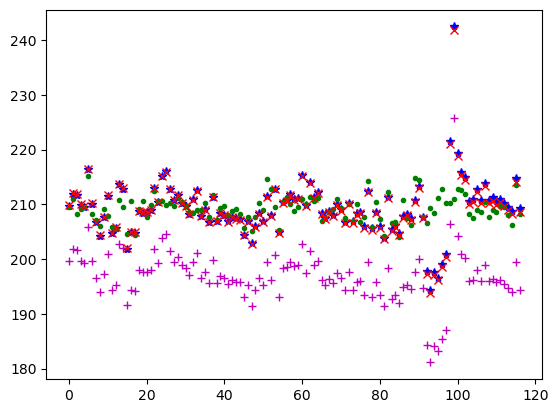

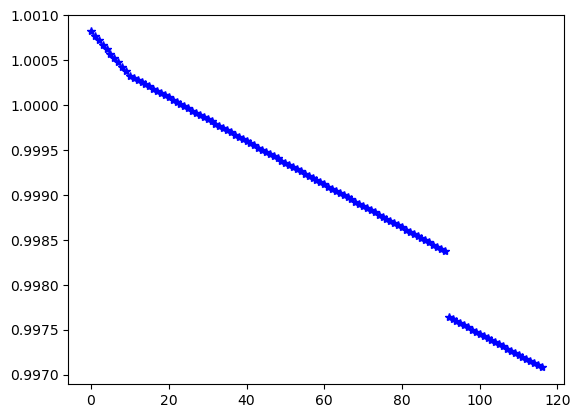

[1.72152658e-05 1.04967266e+00]


In [ ]:
plt.figure()
plt.plot(np.polyval(Derive_Locodox1,delta_T)*PPOX1,'*b')
plt.plot(PPOX1,'+m')
plt.plot(NCEP_PPOX,'.g')
#plt.plot((Derive_Locodox1[0]*delta_T+Derive_Locodox1[1])*PPOX1,'xr')
plt.plot(Gain_Derive * (1 + (Derive * delta_T)/(365*100)) * PPOX1, 'xr')
plt.figure()
plt.plot(Gain_Derive * (1 + (Derive * delta_T)/(365*100)) * PPOX1 / (np.polyval(Derive_Locodox1,delta_T)*PPOX1),'*b')
plt.show()
print(Derive_Locodox1)

In [22]:
print(PPOX1)


[199.66973877 201.78134155 201.58963013 199.69065857 199.33520508
 205.8067627  199.71911621 196.4928894  194.07432556 197.24052429
 200.86282349 194.31103516 195.25875854 202.82449341 201.96932983
 191.5536499  194.43025208 194.23910522 198.01321411 197.65571594
 197.67411804 197.99081421 201.89068604 199.33145142 203.90356445
 204.57672119 201.54859924 199.52238464 200.34588623 198.93667603
 198.41967773 197.04370117 199.52874756 201.04589844 196.58758545
 197.68969727 195.55995178 199.83616638 195.6103363  196.97459412
 196.60403442 195.43571472 196.23730469 195.88653564 195.7293396
 193.03460693 195.31512451 191.48243713 194.33906555 196.60873413
 195.24356079 199.44476318 196.12493896 200.69975281 193.10900879
 198.38504028 198.63673401 199.5519104  198.69332886 198.85910034
 202.81999207 197.5451355  201.56573486 199.00662231 199.69720459
 196.17782593 195.27900696 196.36724854 195.62709045 197.50442505
 196.59585571 194.38308716 197.58248901 194.43626404 195.75483704
 195.987457

In [23]:
print(Derive_Locodox1)

[1.72152658e-05 1.04967266e+00]


In [24]:
def model_Gain_Derive(X,G,D):
    return (G * (1 + (D * X[1])/(365*100)) * X[0] )

# Ajustement des paramètres G et D
initial_guess = [1, 0]  # Valeurs initiales pour G et D et C
params_Gain_Derive, covariance,info,mesg,ier = curve_fit(model_Gain_Derive, [PPOX1,delta_T], NCEP_PPOX, p0=initial_guess,nan_policy='omit',full_output=True)
print(params_Gain_Derive)
print(np.sqrt(np.diag(covariance)))
Gain_Derive, Derive = params_Gain_Derive

[1.0505639  0.50892684]
[0.0043184  0.17478419]


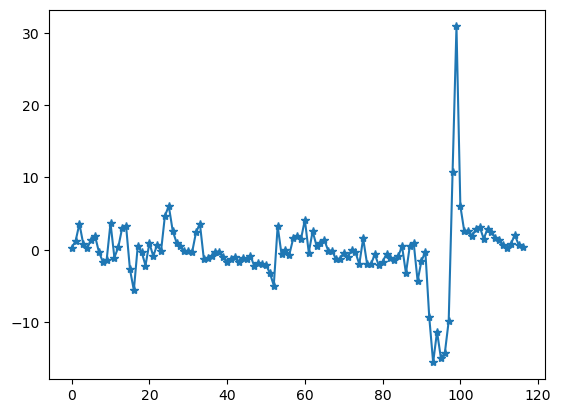

In [25]:
plt.figure()
plt.plot( (Gain_Derive * (1 + (Derive * delta_T)/(365*100)) * PPOX1) - NCEP_PPOX,'*-')
plt.show()

In [26]:
toto = np.median(NCEP_PPOX/(np.polyval(Derive_Locodox1,delta_T)*PPOX1))
print(toto)
print(toto*Derive_Locodox1[1])
toto = np.mean(NCEP_PPOX/(np.polyval(Derive_Locodox1,delta_T)*PPOX1))
print(toto)
print(toto*Derive_Locodox1[1])

1.0003323583166044
1.0500215240788024
0.9999998496142781
1.0496724987858752


In [48]:
# Sans CarryOver
def model_Gain_Derive_Locodox(X,G):
    return X * G

initial_guess = 1
params_Locodox_test, covariance = curve_fit(model_Gain_Derive_Locodox,(params_test[0]*delta_T+params_test[1])*PPOX1 , NCEP_PPOX, p0=initial_guess)

initial_guess = 1
params_Locodox, covariance = curve_fit(model_Gain_Derive_Locodox, np.polyval(Derive_Locodox1,delta_T)*PPOX1, NCEP_PPOX, p0=initial_guess)
Gain_Locodox1 = params_Locodox
#print(params_Locodox)
#print(np.sqrt(np.diag(covariance)))

# On en deduit D associe a la formule G * (1 + D / 100 * delta_T/365) * PPOX1 
def model_Locodox(X, G, D):
    return (G * (1 + (D * X[1])/(365*100)) * X[0] )
#    return  G * (1 + D / 100 * X[1]/365)  * X[0] # Sans carry-over

initial_guess = [1, 0]  # Valeurs initiales pour G et D
params_Locodox, covariance = curve_fit(model_Locodox, [PPOX1,delta_T], Gain_Locodox1*np.polyval(Derive_Locodox1,delta_T)*PPOX1, p0=initial_guess)
params_Locodox_V2, covariance = curve_fit(model_Locodox, [PPOX1,delta_T], params_Locodox_test*(params_test[0]*delta_T+params_test[1])*PPOX1, p0=initial_guess)


#params_Locodox, covariance = curve_fit(model_Locodox, [PPOX1,delta_T], np.polyval(Derive_Locodox1,delta_T)*PPOX1, p0=initial_guess)
print(params_Locodox)
print(params_Locodox_V2)

print(np.sqrt(np.diag(covariance)))
#Gain_Locodox, Derive_Locodox = params_Locodox
Gain_Locodox = Gain_Locodox1 * Derive_Locodox1[1]
Derive_Locodox = Derive_Locodox1[0]*100*365/Derive_Locodox1[1]
print(Gain_Locodox,Derive_Locodox)
print(Gain_Derive,Derive)


[0.9987912]
[0.00230035]
[0.00501917 0.52687552]
[0.00502824 0.43806291]
[9.49793081e-20 8.02026448e-16]
[0.00501917] 0.5268755236305201
1.0505639024882532 0.5089268375093455


In [47]:
# Sans CarryOver
def model_Gain_Derive_Locodox(X,G):
    return X * G

initial_guess = 1
params_Locodox, covariance = curve_fit(model_Gain_Derive_Locodox, np.polyval(Derive_Locodox1,delta_T)*PPOX1, NCEP_PPOX, p0=initial_guess)
Gain_Locodox1 = params_Locodox
#print(np.sqrt(np.diag(covariance)))

# On en deduit D associe a la formule G * (1 + D / 100 * delta_T/365) * PPOX1 
def model_Locodox(X, G, D):
    return (G * (1 + (D * X[1])/(365*100)) * X[0] )
#    return  G * (1 + D / 100 * X[1]/365)  * X[0] # Sans carry-over

initial_guess = [1, 0]  # Valeurs initiales pour G et D
params_Locodox, covariance = curve_fit(model_Locodox, [PPOX1,delta_T], Gain_Locodox1*np.polyval(Derive_Locodox1,delta_T)*PPOX1, p0=initial_guess)


#params_Locodox, covariance = curve_fit(model_Locodox, [PPOX1,delta_T], np.polyval(Derive_Locodox1,delta_T)*PPOX1, p0=initial_guess)
print(params_Locodox)
print(np.sqrt(np.diag(covariance)))
#Gain_Locodox, Derive_Locodox = params_Locodox
Gain_Locodox = Gain_Locodox1 * Derive_Locodox1[1]
Derive_Locodox = Derive_Locodox1[0]*100*365/Derive_Locodox1[1]
print(Gain_Locodox,Derive_Locodox)
print(Gain_Derive,Derive)

[0.00501917 0.52687552]
[1.30536588e-19 1.10626735e-15]
[0.00501917] 0.5268755236305201
1.0505639024882532 0.5089268375093455


In [29]:
#print(Gain_Derive * (1 + Derive / 100 * 12/365) * 200)
#print(Gain_Locodox * (1 + Derive_Locodox / 100 * 12/365) * 200)
#toto=Gain_Locodox * (1 + Derive_Locodox / 100 * delta_T/365) * PPOX1
#print(toto[21])
#toto2=Gain_Derive * (1 + Derive / 100 * delta_T/365) * PPOX1
#print(toto2[21])

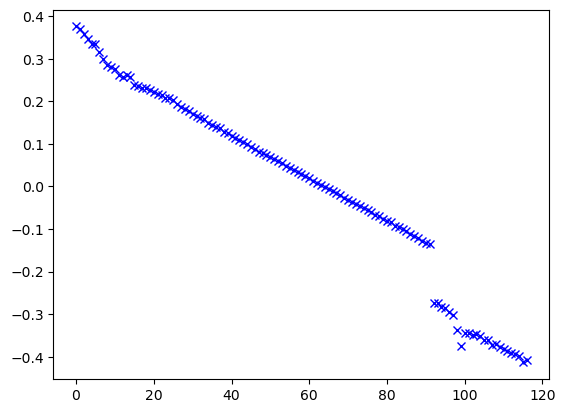

In [30]:
plt.figure()
plt.plot((Gain_Derive * (1 + Derive / 100 * delta_T/365) * PPOX1) - (Gain_Locodox * (1 + Derive_Locodox / 100 * delta_T/365) * PPOX1),'xb')

In [31]:
print(Gain_Locodox,Derive_Locodox)
print(params_Locodox)

[1.04865162] 0.5986220548359624
[1.04865162 0.59862205]


In [35]:
# Avec CarryOver
PPOX2 = np.polyval(Derive_Locodox1,delta_T)*PPOX2
def model_Gain_Derive_Locodox_CarryOver(X,G,C):
    return G / (1-C) * (X - C * PPOX2) # C : Carry-over

initial_guess = [1,0]
params_Locodox, covariance = curve_fit(model_Gain_Derive_Locodox_CarryOver, np.polyval(Derive_Locodox1,delta_T)*PPOX1, NCEP_PPOX, p0=initial_guess)
Gain_Locodox_CarryOver1, C_estime = params_Locodox

def model_Locodox2(X,G,D,C):
    return (G/(1-C) * (1 + D / 100 * X[2]/365) * (X[0] - C * X[1]) )

#def model_Locodox3(X,G,D,C):
#    return (G/(1-C) * (1 + D / 100 * delta_T/365) * (X - C * PPOX2) )
    
initial_guess = [1, 0, 0]  # Valeurs initiales pour G et D
params_Locodox_CarryOver, covariance = curve_fit(model_Locodox2, [PPOX1,PPOX2,delta_T], Gain_Locodox_CarryOver1*np.polyval(Derive_Locodox1,delta_T)*PPOX1, p0=initial_guess)  
#params_Locodox_CarryOver, covariance = curve_fit(model_Locodox3, Gain_Locodox_CarryOver1*np.polyval(Derive_LOCODOX1,delta_T)*PPOX1, Gain_Locodox_CarryOver1*np.polyval(Derive_LOCODOX1,delta_T)*PPOX1,p0=initial_guess)  
print(params_Locodox_CarryOver)

Gain_Locodox_CarryOver = Gain_Locodox_CarryOver1 * Derive_Locodox1[1]
Derive_Locodox_CarryOver = Derive_Locodox1[0]*100*365/Derive_Locodox1[1]

print(Gain_Locodox,Derive_Locodox)
print(Gain_Derive,Derive)
print(Gain_Locodox_CarryOver,Derive_Locodox_CarryOver)
print(Gain_Derive_CarryOver,Derive_CarryOver)

[1.04894435e+00 5.98622057e-01 2.10336216e-09]
[1.04865162] 0.5986220548359624
1.0505639024882532 0.5089268375093455
1.048944352683347 0.5986220548359624
1.0491167424077168 0.5904557336542134


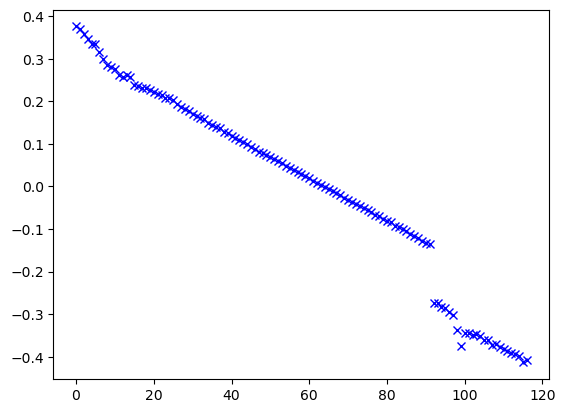

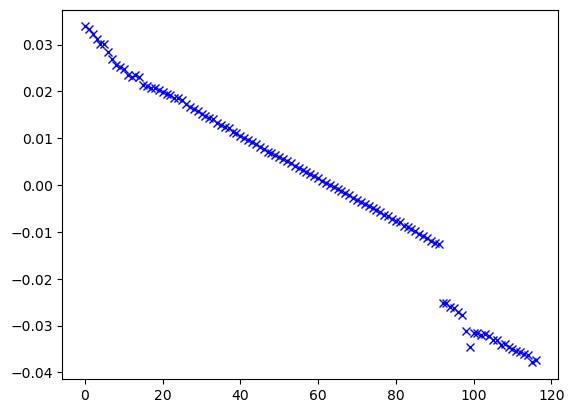

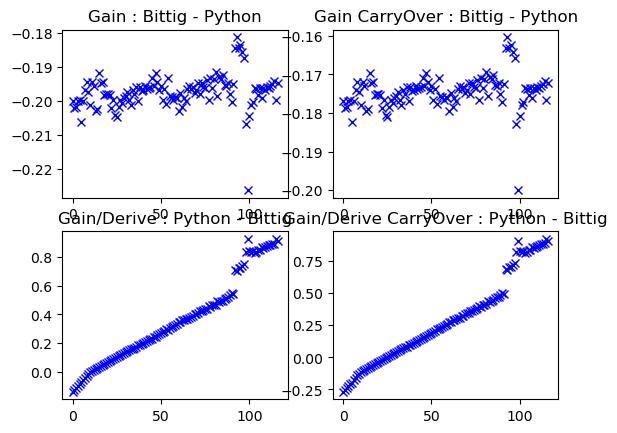

201.78134155273438
212.07916711060167
212.2053685480709
211.80221995388592
212.05639065268062


In [36]:
Gain_Derive_bittig = 1.0513
Derive_bittig = 0.389
Gain_Derive_bittig_CarryOver = 1.0505
Derive_bittig_CarryOver = 0.456
Gain_bittig = 1.0605
Gain_bittig_CarryOver = 1.0608
plt.figure()
plt.plot(Gain_Derive * (1 + Derive / 100 * delta_T/365) * PPOX1 - Gain_Locodox * (1 + Derive_Locodox / 100 * delta_T/365) * PPOX1,'xb')
plt.figure()
plt.plot(Gain_Derive_CarryOver * (1 + Derive_CarryOver / 100 * delta_T/365) * PPOX1 - Gain_Locodox_CarryOver * (1 + Derive_Locodox_CarryOver / 100 * delta_T/365) * PPOX1,'xb')

plt.figure()
plt.subplot(2,2,1)
plt.plot(Gain_bittig *  PPOX1 - Gain * PPOX1,'xb')
plt.title('Gain : Bittig - Python')
plt.subplot(2,2,2)
plt.plot(Gain_bittig_CarryOver *  PPOX1 - Gain_CarryOver * PPOX1,'xb')
plt.title('Gain CarryOver : Bittig - Python')
plt.subplot(2,2,3)
plt.plot(Gain_Derive * (1 + Derive / 100 * delta_T/365) * PPOX1 - Gain_Derive_bittig * (1 + Derive_bittig / 100 * delta_T/365) * PPOX1,'xb')
plt.title('Gain/Derive : Python - Bittig')
plt.subplot(2,2,4)
plt.plot(Gain_Derive_CarryOver * (1 + Derive_CarryOver / 100 * delta_T/365) * PPOX1 - Gain_Derive_bittig_CarryOver * (1 + Derive_bittig_CarryOver / 100 * delta_T/365) * PPOX1,'xb')
plt.title('Gain/Derive CarryOver : Python - Bittig')
plt.show()

print(PPOX1[1])
print(Gain_Derive * (1 + Derive / 100 * delta_T[1]/365) * PPOX1[1])
print(Gain_Derive_bittig * (1 + Derive_bittig / 100 * delta_T[1]/365) * PPOX1[1])
print(Gain_Derive_CarryOver * (1 + Derive_CarryOver / 100 * delta_T[1]/365) * PPOX1[1])
print(Gain_Derive_bittig_CarryOver * (1 + Derive_bittig_CarryOver / 100 * delta_T[1]/365) * PPOX1[1])
